<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/4%20-%20Networks/6.439%20-%20Problem%20Set%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 - Statistics, Computation and Applications

(c) Felipe del Canto, November 2021
***
***

_Note: The dataset for this assignment was provided for in class use only. For this reason, this notebook will not run. I will try to provide a toy dataset in the future._

# Part 0 (Execute first!)

In [23]:
# Import packages
import scipy
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import seaborn           as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

# Problem 4.2: Co-offending Network

## Preamble

In [21]:
# Load data
co_off = pd.read_csv("Cooffending.csv")

# Set date
co_off['date'] = pd.to_datetime(co_off['date'])

# Set crime codes, counties and locations as categorical
categorical_vars = (['offender_id', 'sex', 'event_id'] 
                    + [f'crime{k}_code' for k in range(1,5)] 
                    + ['county', 'location'])
co_off[categorical_vars] = co_off[categorical_vars].astype('category')

## (a), (b), (c), (d): Data exploration

This dataset contains 1,280,459 entries. Each observation is taken at the `offender_id`-`event_id` level, this is, individual offenders arrested at a given crime event.





In [67]:
co_off.shape[0]

1280459

Within, the number of unique offenders is 539,593, and the number of different crime events are 1,164,836, which occurred between 2003 and 2010 according to the following table:

| Year | Number of arrests |
|:--:|:--:|
| 2003  |	122,284 |
| 2004	| 133,705 |
| 2005	| 188,115 |
| 2006  |	203,381 |
| 2007  |	214,315 |
| 2008	| 220,791 |
| 2009	| 197,861 |
| 2010	| 7

In [27]:
co_off.describe(include='all', datetime_is_numeric=True)

,offender_id,dob,sex,event_id,date,year,location,county,crime1_code,crime2_code,crime3_code,crime4_code,minors,adults
count,1280459.0000,1280459.0000,1280459.0000,1280459.0000,1280459,1280459.0000,1280459,1280459.0000,1280459,1280459,1280459,1280459,1280459.0000,1280459.0000
unique,539593.0000,nan,2.0000,1164836.0000,NaN,nan,99,1342.0000,295,244,178,116,nan,nan
top,300728.0000,nan,1.0000,27849.0000,NaN,nan,1,66023.0000,1430,,,,nan,nan
freq,456.0000,nan,1079224.0000,156.0000,NaN,nan,190114,330496.0000,138549,1130107,1250407,1273533,nan,nan
mean,nan,1973.4897,nan,nan,2006-11-02 13:31:11.916521472,2006.3336,NaN,nan,NaN,NaN,NaN,NaN,0.0197,1.3399
min,nan,1007.0000,nan,nan,2003-01-01 00:00:00,2003.0000,NaN,nan,NaN,NaN,NaN,NaN,0.0000,0.0000
25%,nan,1964.0000,nan,nan,2005-05-17 00:00:00,2005.0000,NaN,nan,NaN,NaN,NaN,NaN,0.0000,1.0000
50%,nan,1976.0000,nan,nan,2006-12-16 00:00:00,2006.0000,NaN,nan,NaN,NaN,NaN,NaN,0.0000,1.0000
75%,nan,1984.0000,nan,nan,2008-06-18 00:00:00,2008.0000,NaN,nan,NaN,NaN,NaN,NaN,0.0000,1.0000
max,nan,2005.0000,nan,nan,2010-01-25 00:00:00,2010.0000,NaN,nan,NaN,NaN,NaN,NaN,92.0000,156.0000


In [31]:
co_off[['year', 'event_id']].groupby(['year']).count()

,event_id
year,
2003,122284
2004,133705
2005,188115
2006,203381
2007,214315
2008,220791
2009,197861
2010,7


We can observe a total of 295 different crime codes (different offenses). Of these, 1450 are unlabeled.

In [71]:
different_crime_codes = co_off['crime1_code'].unique().size
print(f'There are {different_crime_codes} number of different crimes in this database.')

print('\nHere is the number of offenders for each crime code:')
co_off[['crime1_code', 'offender_id']].groupby(['crime1_code']).count()

There are 295 number of different crimes in this database.

Here is the number of offenders for each crime code:


,offender_id
crime1_code,
,1450
1110,306
1120,137
1130,51
1140,2
...,...
9330,352
9420,3
9430,1


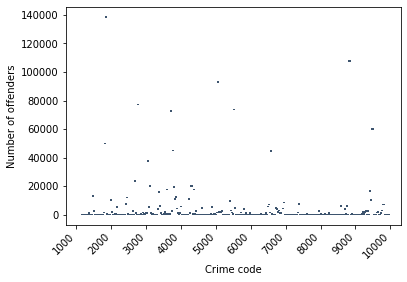

In [104]:
# Axis offsets
offset = (10,1000)
# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.histplot(data=co_off[co_off['crime1_code'] != " "].groupby(['crime1_code']).count(), x='crime1_code', y='offender_id', ax = ax)

# Set xticks
xticks = [300/9 * k - 5 for k in range(10)]
xlabels = [1000 * k for k in range(1,11)]

plt.xticks(ticks=xticks, labels=xlabels, rotation=45, horizontalalignment = 'right')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [20000 * k for k in range(8)]
ylabels = yticks

plt.yticks(yticks, ylabels)

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenders")

fig.show()

In [61]:
co_off[co_off['crime1_code'] == " "]

,offender_id,dob,sex,event_id,date,year,location,county,crime1_code,crime2_code,crime3_code,crime4_code,minors,adults
4182,4511,1918,1,979665,2005-09-03,2005,,81017,,,,,0,1
4522,5111,1921,1,1009145,2009-03-17,2009,,81017,,,,,0,1
4546,5146,1921,0,995179,2007-08-07,2007,,81017,,,,,0,1
4847,5686,1923,1,979616,2005-09-01,2005,,81017,,,,,0,1
5161,6171,1924,1,991280,2007-02-24,2007,,81017,,,,,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274295,665634,1996,1,1003930,2008-08-07,2008,,81017,,,,,0,1
1274890,666074,1996,1,996150,2007-09-16,2007,,81017,,,,,0,1
1276880,667591,1997,1,993606,2007-05-30,2007,,81017,,,,,0,1
1278202,668622,1997,1,1001538,2008-05-06,2008,,81017,,,,,0,1


In [64]:
co_off[co_off['crime1_code'] != " "].describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,offender_id,dob,sex,event_id,date,year,location,county,crime1_code,crime2_code,crime3_code,crime4_code,minors,adults
count,1279009.0000,1279009.0000,1279009.0000,1279009.0000,1279009,1279009.0000,1279009,1279009.0000,1279009,1279009,1279009,1279009,1279009.0000,1279009.0000
unique,538847.0000,nan,2.0000,1163423.0000,2561,nan,99,1342.0000,294,244,178,116,nan,nan
top,300728.0000,nan,1.0000,27849.0000,2009-06-24 00:00:00,nan,1,66023.0000,1430,,,,nan,nan
freq,456.0000,nan,1078106.0000,156.0000,904,nan,190114,330496.0000,138549,1128657,1248957,1272083,nan,nan
first,nan,nan,nan,nan,2003-01-01 00:00:00,nan,NaN,nan,NaN,NaN,NaN,NaN,nan,nan
last,nan,nan,nan,nan,2010-01-25 00:00:00,nan,NaN,nan,NaN,NaN,NaN,NaN,nan,nan
mean,nan,1973.4881,nan,nan,NaN,2006.3321,NaN,nan,NaN,NaN,NaN,NaN,0.0197,1.3402
std,nan,13.7969,nan,nan,NaN,1.8870,NaN,nan,NaN,NaN,NaN,NaN,0.2622,2.5815
min,nan,1007.0000,nan,nan,NaN,2003.0000,NaN,nan,NaN,NaN,NaN,NaN,0.0000,0.0000
25%,nan,1964.0000,nan,nan,NaN,2005.0000,NaN,nan,NaN,NaN,NaN,NaN,0.0000,1.0000


## (b)

## (c)

## (d)

## (e)

## (f)

## (g)

## (h)

## (i)

## (j)

## (k)

## (l)

## (m)